In [1]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")

In [2]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor

In [3]:
def load_model_transform(modelname, device="cuda"):
    # Prepare model and transforms
    if modelname == "resnet50_robust":
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50":
        model = resnet50(pretrained=True)
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50_clip":
        import clip
        model_clip, preprocess = clip.load('RN50', device=device)
        model = model_clip.visual
        transforms_pipeline = preprocess
    elif modelname == "resnet50_dino":
        # https://github.com/facebookresearch/dino
        model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError(f"Unknown model: {modelname}")
        # model = timm.create_model(modelname, pretrained=True).to(device).eval()
        # data_config = timm.data.resolve_model_data_config(model)
        # transforms_pipeline = timm.data.create_transform(**data_config, is_training=False)
    model = model.to(device).eval()
    model.requires_grad_(False)
    
    return model, transforms_pipeline

In [4]:
subject_id =  'paul_20241119' 
modelname = "resnet50_robust"
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
fit_models_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth"))
Xtfmer_lyrswp_RidgeCV = th.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), "rb"))
result_df_lyrswp_RidgeCV = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
pred_data = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))

In [5]:
result_df_lyrswp_RidgeCV

,Unnamed: 0,Unnamed: 1,alpha,train_score,test_score,n_feat
0,.layer4.Bottleneck0_srp,RidgeCV,[1.e+05 1.e+05 1.e+09 1.e+05 1.e+05 1.e+04 1.e...,0.278677,0.065491,5944
1,.layer4.Bottleneck0_pca1000,RidgeCV,[1.e+05 1.e+05 1.e+09 1.e+04 1.e+06 1.e+04 1.e...,0.309205,0.075574,1000
2,.layer4.Bottleneck1_srp,RidgeCV,[1.e+05 1.e+05 1.e+06 1.e+05 1.e+06 1.e+04 1.e...,0.256335,0.068880,5944
3,.layer4.Bottleneck1_pca1000,RidgeCV,[1.e+05 1.e+05 1.e+07 1.e+05 1.e+06 1.e+04 1.e...,0.299131,0.076505,1000
4,.layer4.Bottleneck2_srp,RidgeCV,[1.e+05 1.e+05 1.e+06 1.e+05 1.e+06 1.e+05 1.e...,0.255628,0.071593,5944
5,.layer4.Bottleneck2_pca1000,RidgeCV,[1.e+05 1.e+05 1.e+06 1.e+05 1.e+06 1.e+05 1.e...,0.276667,0.071705,1000


In [6]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id =  'paul_20241119' 
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

In [7]:
chan_msk = ncsnr > 0.8
print(f"Using {chan_msk.sum()} out of {chan_msk.shape[0]} channels")
for k, v in pred_data["D2_per_unit_test_dict"].items():
    print(k, v[chan_msk].mean())

Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.24510798994714875
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.28037262488102976
('.layer4.Bottleneck1_srp', 'RidgeCV') 0.24794823075047642
('.layer4.Bottleneck1_pca1000', 'RidgeCV') 0.2801949067450697
('.layer4.Bottleneck2_srp', 'RidgeCV') 0.2686220619945388
('.layer4.Bottleneck2_pca1000', 'RidgeCV') 0.2682572684280461


In [27]:
key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl")

regressor = fit_models_lyrswp_RidgeCV[key]
Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
pred_rsp = pred_data["pred_dict"][key]
D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]

readout = LinearLayer_from_sklearn(regressor)
th.save(readout.state_dict(), readout_path)
pkl.dump(Xtfmer, open(Xtransform_path, "wb"))
th.save({
    "reliability": reliability,
    "ncsnr": ncsnr,
    "D2_per_unit_test": D2_per_unit_test,
    "D2_per_unit_train": D2_per_unit_train
}, meta_path)

In [35]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id =  'paul_20241119' 
# Load data

for modelname in ["resnet50_robust", "resnet50", "resnet50_clip", "resnet50_dino"]:
    figdir = join(dataroot, "model_outputs", subject_id, )

    fit_models_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth"))
    Xtfmer_lyrswp_RidgeCV = th.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), "rb"))
    result_df_lyrswp_RidgeCV = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    pred_data = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
    data_dict = load_neural_data(data_path, subject_id, stimroot)

    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability']
    ncsnr = data_dict['ncsnr']

    print(f"Model: {modelname}")
    chan_msk = ncsnr > 0.8
    print(f"Using {chan_msk.sum()} out of {chan_msk.shape[0]} channels")
    for k, v in pred_data["D2_per_unit_test_dict"].items():
        print(k, v[chan_msk].mean())

    key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
    # export paths 
    readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
    Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
    meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl")

    regressor = fit_models_lyrswp_RidgeCV[key]
    Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
    pred_rsp = pred_data["pred_dict"][key]
    D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
    D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]

    readout = LinearLayer_from_sklearn(regressor)
    th.save(readout.state_dict(), readout_path)
    pkl.dump(Xtfmer, open(Xtransform_path, "wb"))
    th.save({
        "reliability": reliability,
        "ncsnr": ncsnr,
        "D2_per_unit_test": D2_per_unit_test,
        "D2_per_unit_train": D2_per_unit_train
    }, meta_path)

Model: resnet50_robust
Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.24510798994714875
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.28037262488102976
('.layer4.Bottleneck1_srp', 'RidgeCV') 0.24794823075047642
('.layer4.Bottleneck1_pca1000', 'RidgeCV') 0.2801949067450697
('.layer4.Bottleneck2_srp', 'RidgeCV') 0.2686220619945388
('.layer4.Bottleneck2_pca1000', 'RidgeCV') 0.2682572684280461
Model: resnet50
Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.2636292499760762
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.2733498696896721
('.layer4.Bottleneck1_srp', 'RidgeCV') 0.2549499686043723
('.layer4.Bottleneck1_pca1000', 'RidgeCV') 0.26240913071028354
('.layer4.Bottleneck2_srp', 'RidgeCV') 0.22853612133746357
('.layer4.Bottleneck2_pca1000', 'RidgeCV') 0.23705998307581821
Model: resnet50_clip
Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.26087259310950367
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.2892533977742961
('.layer4

In [32]:
readout_path

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_robust_sweep_regressors_readout_RidgeCV_.layer4.Bottleneck1_pca1000.pth'

In [15]:
# Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
Xtransform_path = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_robust_sweep_regressors_Xtfmer_RidgeCV_.layer4.Bottleneck1_pca1000.pkl'
# readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
readout_path = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_robust_sweep_regressors_readout_RidgeCV_.layer4.Bottleneck1_pca1000.pth' 
modelname = "resnet50_robust"
device = "cuda"
layer_name = ".layer4.Bottleneck1"  #key[0]
model, transforms_pipeline = load_model_transform(modelname, device=device)
model = model.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)

# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)

# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()


def objective_unit(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 1].mean()


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
check_gradient(objective)


# Define the prediction pipeline
def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([])


In [12]:
stimdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/results_fa2"
# list png files in stimdir
png_files = [f for f in os.listdir(stimdir) if f.endswith('.png')]
fa_img_fps = [join(stimdir, f) for f in png_files]

In [17]:
dataset = ImagePathDataset(fa_img_fps, scores=None, transform=transforms_pipeline)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
population_pred = []
for batch in tqdm(dataloader):
    with th.no_grad():
        pred_rsp = population_prediction(batch[0].cuda()).cpu()
        population_pred.append(pred_rsp)
population_pred = th.cat(population_pred, dim=0)

print(population_pred.shape)

The (227, 227) setting is overwritten by the size in custom transform
torch.Size([738, 64])


In [23]:
import re
pattern = r'(\d+)_(\d+)_(pos|neg)_(-?\d+\.\d+)_(-?\d+\.\d+)\.png'
fa_parameters = []
for filename in png_files:
    match = re.match(pattern, filename)
    if match:
        unit_id, img_id, sign, target_score, actual_score = match.groups()
        fa_parameters.append({
            'filename': filename,
            'unit_id': int(unit_id),
            'img_id': int(img_id),
            'sign': sign,
            'target_score': float(target_score),
            'actual_score': float(actual_score)
        })
fa_param_df = pd.DataFrame(fa_parameters)

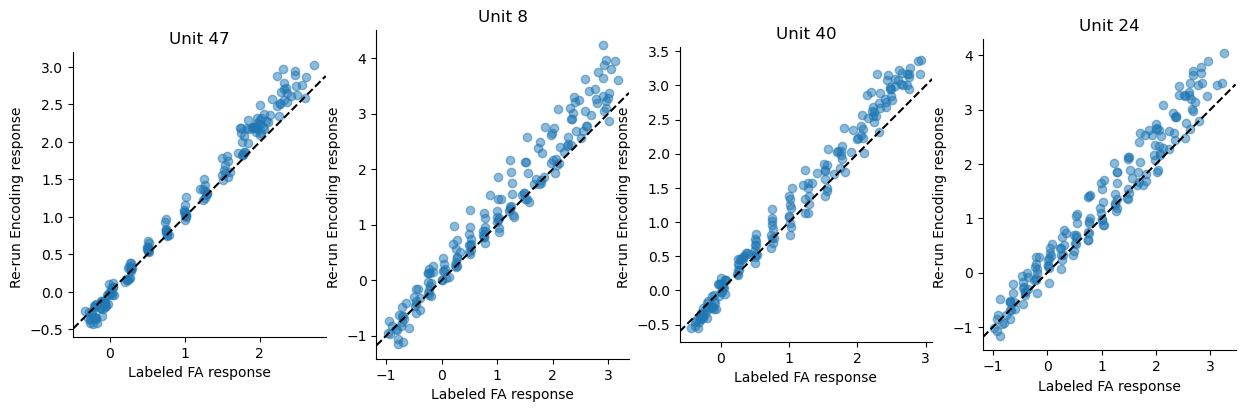

In [37]:
fa_unit_id = 47
fig, axs = plt.subplots(1, 4, figsize=(15, 10))
for fa_unit_id, ax in zip(fa_param_df.unit_id.unique(), axs):
    mask = fa_param_df.unit_id == fa_unit_id
    ax.scatter(fa_param_df[mask].actual_score, population_pred[mask, fa_unit_id].cpu(), alpha=0.5)
    ax.set_xlabel("Labeled FA response")
    ax.set_ylabel("Re-run Encoding response ")
    ax.axline((0, 0), slope=1, color='k', linestyle='--')
    ax.axis('image')
    ax.set_title(f"Unit {fa_unit_id}")
plt.show()

In [19]:
population_pred.cpu()

tensor([[0.7493, 0.3927, 0.4787,  ..., 0.4672, 0.5379, 0.5869],
        [0.8138, 0.5296, 0.4793,  ..., 0.4848, 0.6790, 0.5274],
        [2.2754, 1.3148, 0.4845,  ..., 0.5099, 0.9048, 0.5360],
        ...,
        [1.4443, 0.8077, 0.4816,  ..., 0.5048, 0.6066, 0.5744],
        [1.1014, 0.3979, 0.4807,  ..., 0.4345, 0.4981, 0.5224],
        [0.7694, 0.3105, 0.4789,  ..., 0.4868, 0.6076, 0.5548]])

In [14]:
import re
pattern = r'(\d+)_(\d+)_(pos|neg)_(-?\d+\.\d+)_(-?\d+\.\d+)\.png'
match = re.match(pattern, '47_4_pos_-1.0_-0.034209420531988145.png')
if match:
    unit_id, img_id, sign, target_score, actual_score = match.groups()
    print(f"Image ID: {img_id}")
    print(f"Unit ID: {unit_id}") 
    print(f"Sign: {sign}")
    print(f"Target score: {target_score}")
    print(f"Actual score: {actual_score}")

Image ID: 4
Unit ID: 47
Sign: pos
Target score: -1.0
Actual score: -0.034209420531988145


In [29]:
!echo {figdir}

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119


In [28]:
!ls {figdir}

paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.pdf
paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.png
paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis.pdf
paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis.png
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
paul_20241119_resnet50_clip_sweep_regressors_layers_pred_meta.pkl
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.pdf
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.png
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis.pdf
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis.png
paul_202411

In [25]:
regressor

PCA(n_components=1000)

In [ ]:
device = "cuda"
layer_name = ".layer4.Bottleneck1"  #key[0]
model, transforms_pipeline = load_model_transform(modelname, device=device)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)
# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)
# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()

check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
saveallforms(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_MACO_population_mean")
plt.show()

img_col = []
for unit_id in range(len(D2)):
    print(f"Optimizing unit {unit_id}")
    print(f"D^2: {D2[unit_id]}")

    def unit_objective(images):
        # Forward pass through the feature extractor
        model(images)
        feat_tsr = fetcher[layer_name]  # Access the layer4 feature
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)[:, unit_id].mean()
    
    image_unit, alpha_unit = maco(unit_objective, **maco_hyperparams, device='cuda')
    img_col.append((image_unit, alpha_unit))
    plot_maco(image_unit, alpha_unit)

visualize_results(img_col, D2, )
plt.suptitle(f"{subject_id} {modelname} {layer_name} {RD_method} MACO unit compilation")
saveallforms(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_MACO_unit_cmp")